# Introduction


My research question for this project is, "How are the locations of COVID-19 testing centers in Chicago related to COVID cases and demographic patterns?" I aimed to discover whether the distribution of COVID testing sites was related to COVID case rates or demographic trends (proxied by racial demographics). 

I conducted this research using data from Chicago's Open Data portal. My data layers display COVID case rates by Chicago zip code, racial breakdowns by Census tract, and the locations of COVID testing sites. I loaded in sidewalk data that I hoped to use to create service areas of COVID testing sites, but I ultimately had to use buffers of the testing sites due to time and open source software constraints.

My method of statistical analysis was ANOVA (analysis of variance). This method illustrates the statistical significance of mean-differences between groups.

# Background Literature

Literature throughout the pandemic has shown disparities in the impacts of COVID-19, particulary across racial and ethnic lines. A recent study looking at 6 cities in the U.S. (including Chicago) showed that a 10 percentage point increase in a zip code's Black population is associated with 9.2 additional COVID cases per 10,000 people, and a similar increase in Hispanic residents is associated with 20.6 additional cases. Potential explanations for this increase are disparities in types of jobs (frontline employment vs. employment that can move online), ability (or lack thereof) to move outside of the city during COVID peaks, access to healthcare and testing during the pandemic, and longterm preexisting health disparities (Benitez, Courtemanche, & Yelowitz 2020).

It is also important to examine literature about the history of segregation in the United States and Chicago specifically. Chicago has been used as a model for prototypical American cities (Park and Burgess 1925) and is quite segregated between its predominantly-white suburbs and its predominantly-Black "South Side". In recent decades, however, Chicago has become more diverse overall and has undergone complex racial change including an increase in Hispanic/Latino identifying residents (Onésimo Sandoval 2011).  

One resource about segregation in the US that I find particularly interesting and important is the web map "Mapping Inequality" that was developed by scholars at the University of Richmond, Virginia Tech University, and the University of Maryland. The interactive mapping tool can be found here: https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58. Below is a screenshot of Chicago's redlining maps as found on the Mapping Inequality resource. It shows that most neighborhoods in southern and central Chicago were deemed "Definitely Declining" or "Hazardous" by redlining maps in the 1950s, whereas suburbs to the north and outskirts of the city were deemed "Best" or "Still Desirable". These designations were highly racially charged and illustrate the legacy of segregation on racial breakdowns in Chicago today.

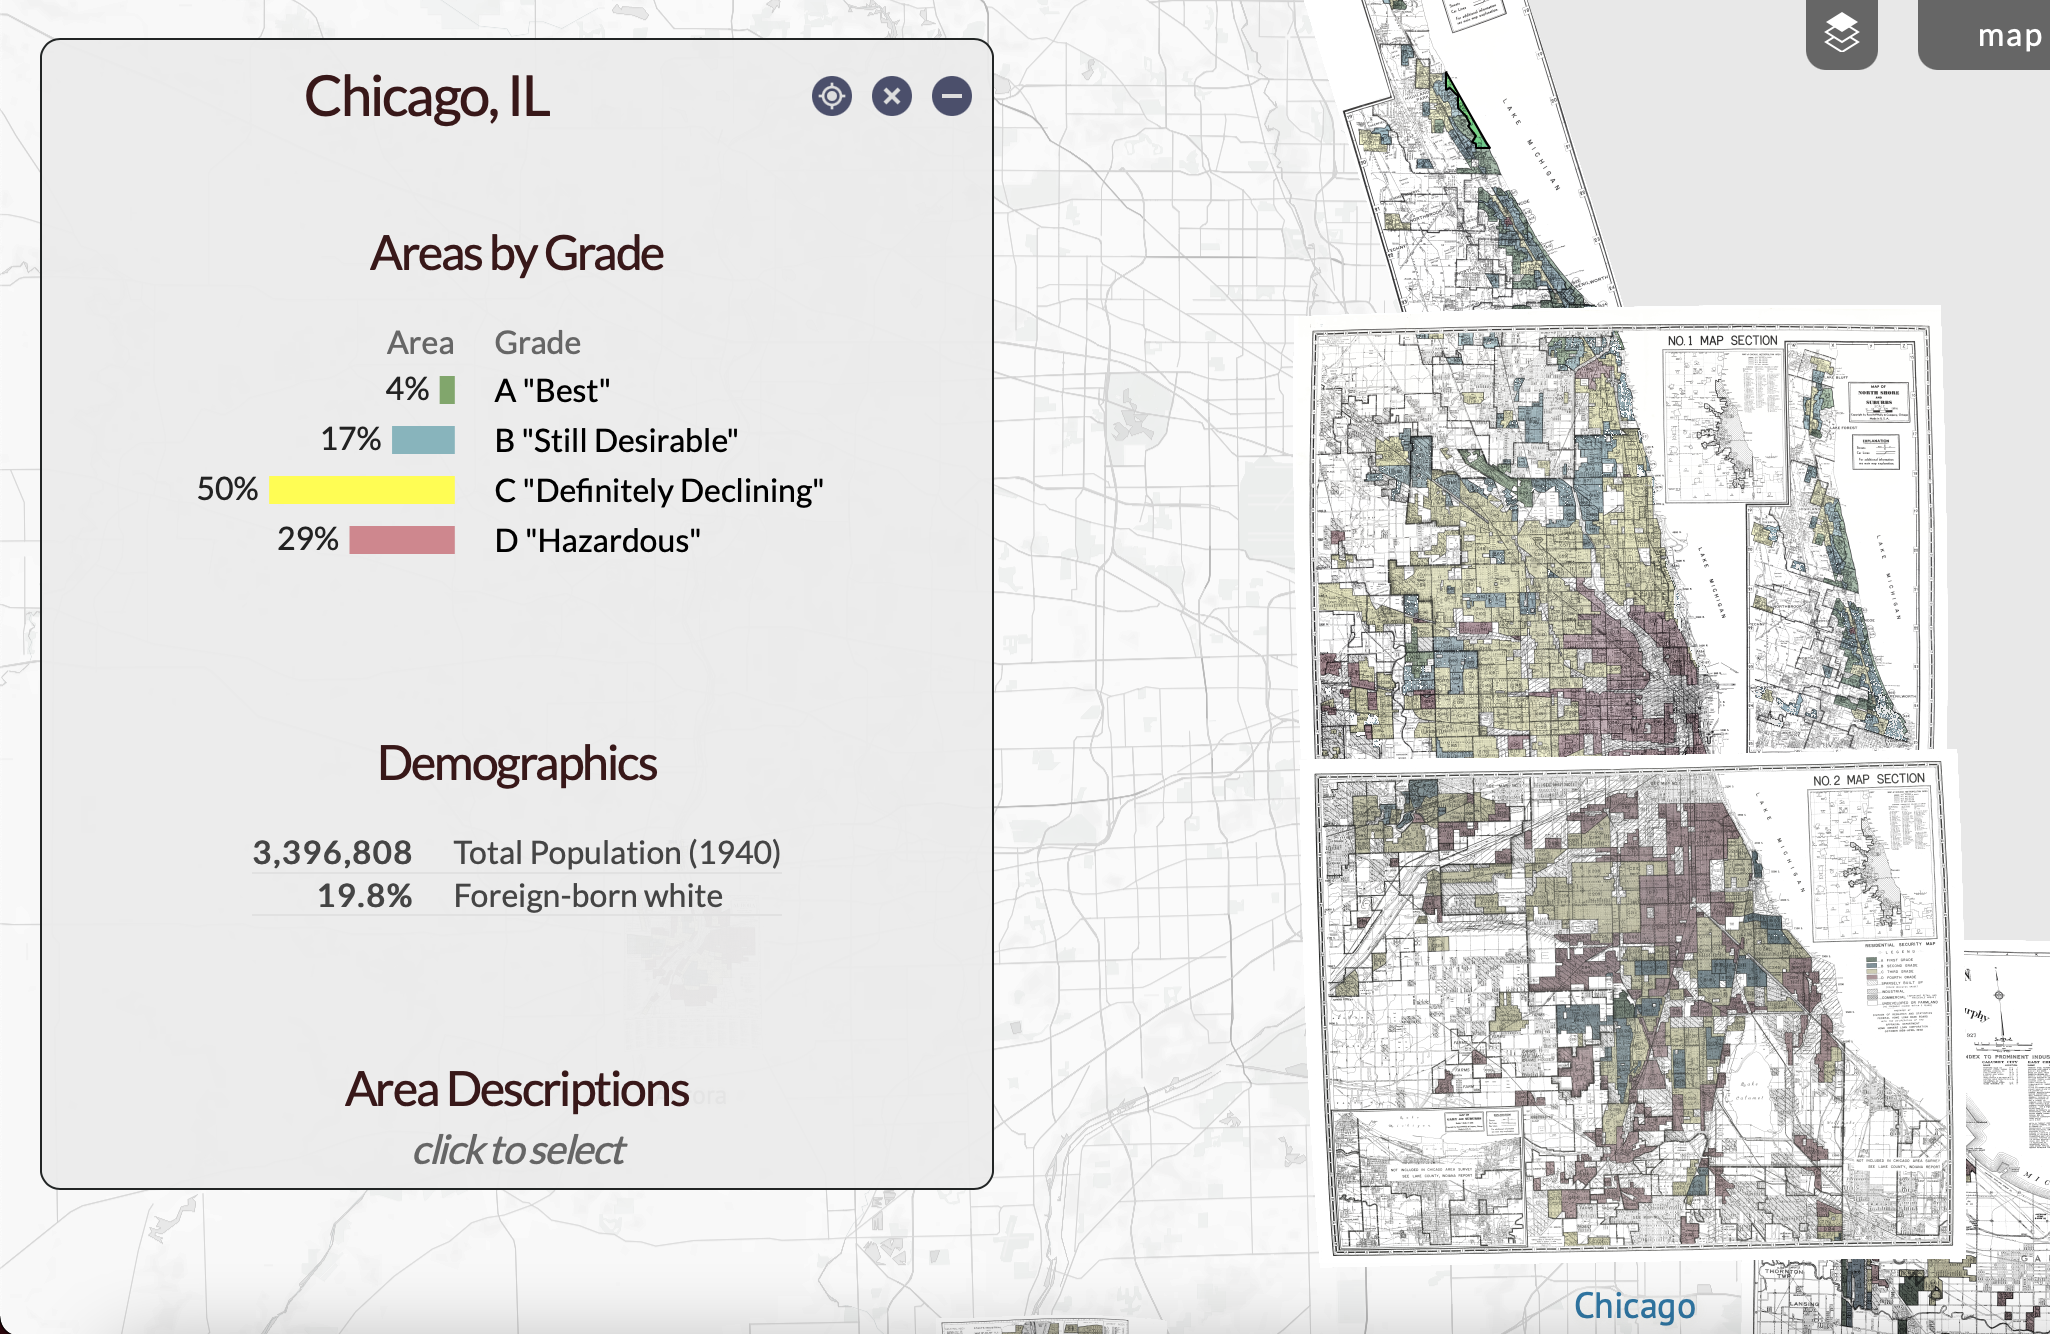

# Data and Data Processing

## Import Packages

In [1]:
#!pip install momepy
import geopandas as gpd
import fiona
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely import wkt
import networkx as nx
import osmnx as ox
import momepy
import scipy.stats as stats
#!pip install statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
!pip install bioinfokit
from bioinfokit.analys import stat

/Users/kearadennehy/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Data Wrangling

I loaded in Chicago's COVID data by zip code and merged it with geospatial data about each zip code.

In [2]:
covidCasesLink = "https://data.cityofchicago.org/api/geospatial/yhhz-zm2v?method=export&format=Shapefile"
casesdf = gpd.read_file(covidCasesLink)

In [3]:
casesdf = casesdf.dropna()

In [4]:
casesdf = casesdf.sort_values(by="date_week_", ascending=False)

In [5]:
casesdf = casesdf.drop(labels="geometry", axis=1)

In [6]:
casesdf.head()

,zip_code,week_numbe,date_week_,time_week_,date_wee_2,time_wee_2,cases_week,cases_cumu,case_rate_,case_rat_2,...,test_rate_,test_rat_2,percent_te,percent__2,deaths_wee,deaths_cum,death_rate,death_ra_2,population,row_id
0,60601,51.0,2021-12-19,00:00:00.000,2021-12-25,00:00:00.000,309.0,2175.0,2105.6,14821.1,...,15304.9,479189.1,0.186,0.036,0.0,12.0,0.0,81.8,14675.0,60601-2021-51
104,60621,51.0,2021-12-19,00:00:00.000,2021-12-25,00:00:00.000,296.0,3861.0,1019.2,13294.5,...,5922.5,252396.5,0.207,0.059,2.0,113.0,6.9,389.1,29042.0,60621-2021-51
2748,60651,51.0,2021-12-19,00:00:00.000,2021-12-25,00:00:00.000,483.0,10371.0,764.0,16405.1,...,4971.7,245064.7,0.180,0.077,1.0,163.0,1.6,257.8,63218.0,60651-2021-51
2972,60652,51.0,2021-12-19,00:00:00.000,2021-12-25,00:00:00.000,444.0,7287.0,1011.2,16596.4,...,5980.8,247798.8,0.212,0.078,2.0,115.0,4.6,261.9,43907.0,60652-2021-51
3156,60653,51.0,2021-12-19,00:00:00.000,2021-12-25,00:00:00.000,420.0,4453.0,1313.6,13927.8,...,7866.3,302752.4,0.208,0.053,2.0,79.0,6.3,247.1,31972.0,60653-2021-51


In [7]:
zipCodesLink = "https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=Shapefile"
zipcodesdf = gpd.read_file(zipCodesLink)

In [8]:
zipcodesdf = zipcodesdf.merge(casesdf, right_on="zip_code", left_on="zip")

In [9]:
zipcodesdf.head()

,objectid,shape_area,shape_len,zip,geometry,zip_code,week_numbe,date_week_,time_week_,date_wee_2,...,test_rate_,test_rat_2,percent_te,percent__2,deaths_wee,deaths_cum,death_rate,death_ra_2,population,row_id
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",60647,51.0,2021-12-19,00:00:00.000,2021-12-25,...,7612.9,306686.2,0.152,0.055,1.0,165.0,1.1,188.6,87509.0,60647-2021-51
1,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",60647,50.0,2021-12-12,00:00:00.000,2021-12-18,...,10069.8,299073.2,0.077,0.053,0.0,164.0,0.0,187.4,87509.0,60647-2021-50
2,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",60647,49.0,2021-12-05,00:00:00.000,2021-12-11,...,7921.5,289003.4,0.040,0.052,1.0,164.0,1.1,187.4,87509.0,60647-2021-49
3,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",60647,48.0,2021-11-28,00:00:00.000,2021-12-04,...,7923.8,281081.9,0.039,0.052,0.0,163.0,0.0,186.3,87509.0,60647-2021-48
4,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",60647,47.0,2021-11-21,00:00:00.000,2021-11-27,...,5303.5,273158.2,0.032,0.052,0.0,163.0,0.0,186.3,87509.0,60647-2021-47


I then chose which columns I was interested in and created a new dataframe with those columns. I then isolated data from the first week of August (the most recent week when I started working on this project). I created a column for cumulative cases per 10,000 people and made the dataframe into a geodataframe.

In [10]:
geometryseries = zipcodesdf["geometry"]
zipseries = zipcodesdf["zip"]
areaseries = zipcodesdf["shape_area"]
lenseries = zipcodesdf["shape_len"]
cumucasesseries = zipcodesdf["cases_cumu"]
zipcodesseries = zipcodesdf["zip"]
datesseries = zipcodesdf["date_week_"]
populationseries = zipcodesdf["population"]
frame = {"zip": zipcodesseries, "week": datesseries, "shape_area": areaseries, "shape_len": lenseries, "geometry": geometryseries, "cumu_cases": cumucasesseries, "population": populationseries}
cumulativecasesdf = pd.DataFrame(frame)

In [11]:
cumulativecasesdf.set_geometry("geometry")

,zip,week,shape_area,shape_len,geometry,cumu_cases,population
0,60647,2021-12-19,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",12566.0,87509.0
1,60647,2021-12-12,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",11767.0,87509.0
2,60647,2021-12-05,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",11226.0,87509.0
3,60647,2021-11-28,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",11004.0,87509.0
4,60647,2021-11-21,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",10786.0,87509.0
...,...,...,...,...,...,...,...
5350,60619,2020-04-12,1.678720e+08,53040.907078,"POLYGON ((-87.58592 41.75150, -87.58592 41.751...",431.0,61258.0
5351,60619,2020-04-05,1.678720e+08,53040.907078,"POLYGON ((-87.58592 41.75150, -87.58592 41.751...",338.0,61258.0
5352,60619,2020-03-29,1.678720e+08,53040.907078,"POLYGON ((-87.58592 41.75150, -87.58592 41.751...",241.0,61258.0
5353,60619,2020-03-22,1.678720e+08,53040.907078,"POLYGON ((-87.58592 41.75150, -87.58592 41.751...",129.0,61258.0


In [12]:
cumulativecasesdf = cumulativecasesdf[cumulativecasesdf["week"]=="2021-08-01"]

In [13]:
cumulativecasesdf["CasesPer10000"] = cumulativecasesdf["cumu_cases"] / cumulativecasesdf["population"] * 10000

In [14]:
cumulativecasesgdf = gpd.GeoDataFrame(
    cumulativecasesdf, geometry=cumulativecasesdf["geometry"])

In [15]:
testingSitesLink = "https://data.cityofchicago.org/api/views/thdn-3grx/rows.csv?accessType=DOWNLOAD"
testingsitesdf = pd.read_csv(testingSitesLink)

In [16]:
testingsitesdf = testingsitesdf.dropna()

In [17]:
testingsitesdf['Location'] = gpd.GeoSeries.from_wkt(testingsitesdf['Location'])
testingsitesgdf = gpd.GeoDataFrame(testingsitesdf, geometry="Location")

In [18]:
cumulativecasesgdf.head()

,zip,week,shape_area,shape_len,geometry,cumu_cases,population,CasesPer10000
20,60647,2021-08-01,1.060523e+08,42720.044406,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",9255.0,87509.0,1057.605503
114,60639,2021-08-01,1.274761e+08,48103.782721,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",14868.0,90517.0,1642.564380
247,60622,2021-08-01,7.085383e+07,42527.989679,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",5492.0,52793.0,1040.289432
341,60651,2021-08-01,9.903962e+07,47970.140153,"POLYGON ((-87.70656 41.89555, -87.70672 41.895...",8205.0,63218.0,1297.889842
434,60611,2021-08-01,2.350606e+07,34689.350631,"POLYGON ((-87.61401 41.89354, -87.61369 41.893...",2448.0,32426.0,754.949732


I loaded sidewalk data from Cook County (Chicago's county) into a geodataframe as well.

In [19]:
sidewalksLink = 'https://datahub.cmap.illinois.gov/dataset/93394557-3315-4b93-ab53-9fd576bf5997/resource/1c1e2d2d-e19e-4752-80f0-bfb1799c99bf/download/SidewalkInventoryCMAP2018.zip'
sidewalksdf = gpd.read_file(sidewalksLink)

In [20]:
sidewalksgdf = gpd.GeoDataFrame(sidewalksdf, geometry="geometry")

I set all geodataframes to EPSG 3435 (NAD83 / Illinois East (ftUS)).

In [21]:
print(sidewalksgdf.crs)
print(cumulativecasesgdf.crs)
print(testingsitesgdf.crs)

epsg:3435
None
None


In [22]:
cumulativecasesgdf = cumulativecasesgdf.set_crs('EPSG:4326')
cumulativecasesgdf = cumulativecasesgdf.to_crs('EPSG:3435')

testingsitesgdf = testingsitesgdf.set_crs('EPSG:4326')
testingsitesgdf = testingsitesgdf.to_crs('EPSG:3435')

I clipped my sidewalk data by the COVID cases (Chicago boundaries).

In [23]:
sidewalksgdf = gpd.clip(sidewalksgdf, cumulativecasesgdf)

Then, I loaded Census tract geospatial data into a geodataframe.

In [24]:
censusTractsLink = "https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=Shapefile"
censustractsgdf = gpd.read_file(censusTractsLink)

In [74]:
censustractsgdf.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,id,Name,Population,PctWhite,PctPOC
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((1177855.557 1845080.015, 1177855.599...",17031842400,"Census Tract 8424, Cook County, Illinois",3304.0,0.009383,0.990617
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((1160668.954 1878739.961, 1160672.597...",17031840300,"Census Tract 8403, Cook County, Illinois",3950.0,0.432911,0.567089
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((1176043.375 1889735.517, 1176045.942...",17031841100,"Census Tract 8411, Cook County, Illinois",7254.0,0.055280,0.944720
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((1160019.224 1890664.257, 1160010.757...",17031841200,"Census Tract 8412, Cook County, Illinois",5262.0,0.444698,0.555302
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((1174950.444 1897631.269, 1174968.419...",17031839000,"Census Tract 8390, Cook County, Illinois",7311.0,0.682396,0.317604


Census demographic data was unable to load in via link. Instead, I found a table here: https://data.census.gov/cedsci/advanced?q=chicago. I downloaded tract-level race data for all of Chicago to my local computer.

In [26]:
racedf = pd.read_csv("/Users/kearadennehy/Downloads/DECENNIALPL2010/DECENNIALPL2010.P1_data_with_overlays_2021-08-19T144646.csv")

In [27]:
racedf.columns = racedf.iloc[0]
racedf = racedf.drop([0])
racedf = racedf.reset_index()
racedf.insert(loc=73, column="PctWhite", value=1.0)

I created columns for percent of the population that is white and percent of the population that is of color. I made a new dataframe called "simpleracedf" with these columns, then merged that dataframe back into my Census geodataframe.

In [28]:
convert_dict = {"Total": float,
                "Total!!Population of one race!!White alone": float
               }
  
racedf = racedf.astype(convert_dict)

racedf["PctWhite"] = racedf["Total!!Population of one race!!White alone"] / racedf["Total"]

racedf["PctPOC"] = 1.0 - racedf["PctWhite"]

In [29]:
idseries = racedf["id"].str.split(pat="1400000US", expand=True)[1]
nameseries = racedf["Geographic Area Name"]
totalpopseries = racedf["Total"]
pctwhiteseries = racedf["PctWhite"]
pctpocseries = racedf["PctPOC"]
frame2 = {"id": idseries, "Name": nameseries, "Population": totalpopseries, "PctWhite": pctwhiteseries, "PctPOC": pctpocseries}
simpleracedf = pd.DataFrame(frame2)
simpleracedf

,id,Name,Population,PctWhite,PctPOC
0,17031010100,"Census Tract 101, Cook County, Illinois",4854.0,0.372888,0.627112
1,17031010201,"Census Tract 102.01, Cook County, Illinois",6450.0,0.358450,0.641550
2,17031010202,"Census Tract 102.02, Cook County, Illinois",2818.0,0.438964,0.561036
3,17031010300,"Census Tract 103, Cook County, Illinois",6236.0,0.523894,0.476106
4,17031010400,"Census Tract 104, Cook County, Illinois",5042.0,0.662634,0.337366
...,...,...,...,...,...
1314,17031843800,"Census Tract 8438, Cook County, Illinois",2110.0,0.291943,0.708057
1315,17031843900,"Census Tract 8439, Cook County, Illinois",3533.0,0.036513,0.963487
1316,17031980000,"Census Tract 9800, Cook County, Illinois",0.0,NaN,NaN
1317,17031980100,"Census Tract 9801, Cook County, Illinois",0.0,NaN,NaN


In [30]:
simpleracedf

,id,Name,Population,PctWhite,PctPOC
0,17031010100,"Census Tract 101, Cook County, Illinois",4854.0,0.372888,0.627112
1,17031010201,"Census Tract 102.01, Cook County, Illinois",6450.0,0.358450,0.641550
2,17031010202,"Census Tract 102.02, Cook County, Illinois",2818.0,0.438964,0.561036
3,17031010300,"Census Tract 103, Cook County, Illinois",6236.0,0.523894,0.476106
4,17031010400,"Census Tract 104, Cook County, Illinois",5042.0,0.662634,0.337366
...,...,...,...,...,...
1314,17031843800,"Census Tract 8438, Cook County, Illinois",2110.0,0.291943,0.708057
1315,17031843900,"Census Tract 8439, Cook County, Illinois",3533.0,0.036513,0.963487
1316,17031980000,"Census Tract 9800, Cook County, Illinois",0.0,NaN,NaN
1317,17031980100,"Census Tract 9801, Cook County, Illinois",0.0,NaN,NaN


In [31]:
censustractsgdf = censustractsgdf.merge(simpleracedf, right_on="id", left_on="geoid10")

In [32]:
censustractsgdf = censustractsgdf.to_crs('EPSG:3435')

Below is my final Census tract geodataframe. It includes columns for percent of the population that is white and percent of the population that is of color.

In [33]:
censustractsgdf

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,id,Name,Population,PctWhite,PctPOC
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((1177855.557 1845080.015, 1177855.599...",17031842400,"Census Tract 8424, Cook County, Illinois",3304.0,0.009383,0.990617
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((1160668.954 1878739.961, 1160672.597...",17031840300,"Census Tract 8403, Cook County, Illinois",3950.0,0.432911,0.567089
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((1176043.375 1889735.517, 1176045.942...",17031841100,"Census Tract 8411, Cook County, Illinois",7254.0,0.055280,0.944720
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((1160019.224 1890664.257, 1160010.757...",17031841200,"Census Tract 8412, Cook County, Illinois",5262.0,0.444698,0.555302
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((1174950.444 1897631.269, 1174968.419...",17031839000,"Census Tract 8390, Cook County, Illinois",7311.0,0.682396,0.317604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((1168156.066 1918746.164, 1168220.001...",17031070400,"Census Tract 704, Cook County, Illinois",2984.0,0.886729,0.113271
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((1166519.701 1917925.392, 1166515.842...",17031070500,"Census Tract 705, Cook County, Illinois",2928.0,0.904030,0.095970
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((1152539.157 1937002.093, 1152443.466...",17031130300,"Census Tract 1303, Cook County, Illinois",5064.0,0.492694,0.507306
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((1153199.386 1890446.375, 1153092.407...",17031292200,"Census Tract 2922, Cook County, Illinois",2961.0,0.022627,0.977373


Below is my final COVID cases geodataframe. It includes cumulative cases per 10,000 people for each zip code.

In [70]:
cumulativecasesgdf

,zip,week,shape_area,shape_len,geometry,cumu_cases,population,CasesPer10000
2,60647,2021-08-01,1.060523e+08,42720.044406,"POLYGON ((1162710.570 1913303.050, 1162715.690...",9224.0,87509.0,1054.063011
78,60639,2021-08-01,1.274761e+08,48103.782721,"POLYGON ((1149304.490 1914985.850, 1149278.070...",14817.0,90517.0,1636.930079
193,60622,2021-08-01,7.085383e+07,42527.989679,"POLYGON ((1165664.482 1902791.860, 1165664.480...",5438.0,52793.0,1030.060804
269,60651,2021-08-01,9.903962e+07,47970.140153,"POLYGON ((1154894.670 1905152.880, 1154849.960...",8168.0,63218.0,1292.037078
344,60611,2021-08-01,2.350606e+07,34689.350631,"POLYGON ((1180096.830 1904616.840, 1180186.790...",2434.0,32426.0,750.632209
419,60638,2021-08-01,1.661663e+08,67710.646739,"POLYGON ((1145038.120 1877098.200, 1145038.830...",8119.0,58797.0,1380.852765
494,60652,2021-08-01,1.283098e+08,48187.949880,"POLYGON ((1161676.040 1854860.750, 1161677.220...",5605.0,43907.0,1276.561824
569,60626,2021-08-01,4.917058e+07,33983.913306,"POLYGON ((1166067.060 1951048.980, 1166072.700...",4564.0,49730.0,917.755882
644,60615,2021-08-01,6.656545e+07,38321.313769,"POLYGON ((1189361.370 1872142.680, 1189398.870...",2610.0,41563.0,627.962370
719,60621,2021-08-01,1.047468e+08,42299.920391,"POLYGON ((1177515.860 1857917.930, 1177516.630...",2504.0,29042.0,862.199573


Below is my final testing sites geodataframe.

In [71]:
testingsitesgdf

,Facility,Phone,Address,Web Site,Location,buffered,geometry
0,Heartland Health Center - Edgewater,(773) 751-7800,"1300 W Devon Ave Chicago, IL 60660",https://www.heartlandhealthcenters.org/covid-1...,POINT (1166403.189 1942634.785),"POLYGON ((1169043.189 1942634.785, 1169030.477...","POLYGON ((1169043.189 1942634.785, 1169030.477..."
1,University of Chicago Hospital - Hyde Park,(773) 702-2800,"901 E 58th St Chicago, IL 60637",https://www.uchicagomedicine.org/patients-visi...,POINT (1183231.010 1866746.946),"POLYGON ((1185871.010 1866746.946, 1185858.298...","POLYGON ((1185871.010 1866746.946, 1185858.298..."
2,Near North Health Service Corporation: Chicago...,(773) 227-8022,"1734 W Chicago Ave Chicago, IL 60622",https://www.nearnorthhealth.org/,POINT (1164527.323 1905394.543),"POLYGON ((1167167.323 1905394.543, 1167154.611...","POLYGON ((1167167.323 1905394.543, 1167154.611..."
3,Aayu Clinics - Lakeview,(773) 227-3669,"1645 A W School St Chicago, IL 60657",https://www.aayuclinics.com/services-1,POINT (1164655.887 1921973.142),"POLYGON ((1167295.887 1921973.142, 1167283.175...","POLYGON ((1167295.887 1921973.142, 1167283.175..."
4,Loretto Hospital,(773) 854-5475,"645 S Central Ave Chicago, IL 60644",https://www.lorettohospital.org/covid-19-testing/,POINT (1139191.328 1896475.545),"POLYGON ((1141831.328 1896475.545, 1141818.615...","POLYGON ((1141831.328 1896475.545, 1141818.615..."
...,...,...,...,...,...,...,...
142,Lurie Children's Hospital,(312) 227-5300,"225 E Chicago Ave, IL 60611",https://www.luriechildrens.org/en/news-stories...,POINT (1177937.863 1905767.195),"POLYGON ((1180577.863 1905767.195, 1180565.150...","POLYGON ((1180577.863 1905767.195, 1180565.150..."
143,PCC Community Wellness Center - Salud,(773) 295-3347,"5359 W Fullerton Ave Chicago, IL 60639",https://www.pccwellness.org/covid-19?id=177,POINT (1140143.113 1915425.287),"POLYGON ((1142783.113 1915425.287, 1142770.401...","POLYGON ((1142783.113 1915425.287, 1142770.401..."
144,PrimeCare - Northwest Health Center,(312) 633-5841,"1649 N Pulaski Rd Chicago, IL 60639",https://primecarehealth.org/northwest-health-c...,POINT (1149453.628 1910853.567),"POLYGON ((1152093.628 1910853.567, 1152080.916...","POLYGON ((1152093.628 1910853.567, 1152080.916..."
145,"John H. Stroger, Jr. Cook County Hospital",(312) 864-6000,"1969 W Ogden Ave Chicago, IL 60612",https://cookcountyhealth.org/locations/john-h-...,POINT (1163307.419 1897094.229),"POLYGON ((1165947.419 1897094.229, 1165934.707...","POLYGON ((1165947.419 1897094.229, 1165934.707..."


## Data Analysis

I pulled one testing site out of my testing sites geodataframe to try and complete my network analysis. I ultimately was unable to perform network analysis, but I kept the small sidewalk visualizations I made to give a glimpse into my process and to show the sidewalk data that I loaded into the notebook.

In [34]:
testingsitesgdf.loc[0]

Facility                  Heartland Health Center - Edgewater
Phone                                          (773) 751-7800
Address                    1300 W Devon Ave Chicago, IL 60660
Web Site    https://www.heartlandhealthcenters.org/covid-1...
Location          POINT (1166403.189108892 1942634.785260455)
Name: 0, dtype: object

In [35]:
samplesite = gpd.GeoDataFrame(testingsitesgdf.loc[0])
samplesite = samplesite.transpose()
samplesite

,Facility,Phone,Address,Web Site,Location
0,Heartland Health Center - Edgewater,(773) 751-7800,"1300 W Devon Ave Chicago, IL 60660",https://www.heartlandhealthcenters.org/covid-1...,POINT (1166403.189108892 1942634.785260455)


<AxesSubplot:>

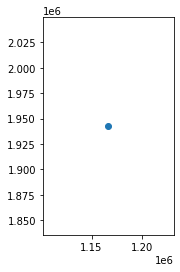

In [36]:
samplesite = samplesite.set_geometry("Location")
samplesite = samplesite.set_crs('EPSG:3435')
samplesite.plot()

In [37]:
samplesite.crs

<Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

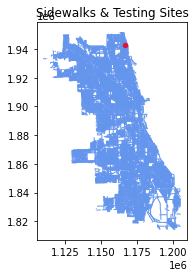

In [38]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_title('Sidewalks & Testing Sites')

sidewalksgdf.plot(ax=ax, color='cornflowerblue', linewidth=1, zorder=0)

#testingsitesgdf.plot(ax=ax, color='crimson', zorder=10, markersize=20)
samplesite.plot(ax=ax, color='crimson', zorder=10, markersize=20)

plt.show();

I tested a buffer on the sample site once I realized I would be unable to complete network analysis.

In [39]:
samplesite["buffered"] = samplesite.buffer(2640)

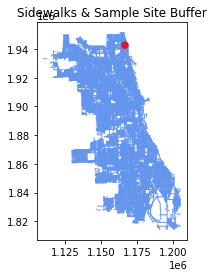

In [40]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.set_title('Sidewalks & Sample Site Buffer')

sidewalksgdf.plot(ax=ax, color='cornflowerblue', linewidth=1, zorder=0)

#testingsitesgdf.plot(ax=ax, color='crimson', zorder=10, markersize=20)
samplesite["buffered"].plot(ax=ax, color='crimson', zorder=10, markersize=20)

plt.show();

I decided to go with a half mile buffer for each testing site to get a sense of areas that have readily accessible testing sites.

In [41]:
testingsitesgdf["buffered"] = testingsitesgdf.buffer(2640)
buffered_sites = gpd.GeoDataFrame(data=testingsitesgdf, geometry=testingsitesgdf["buffered"])

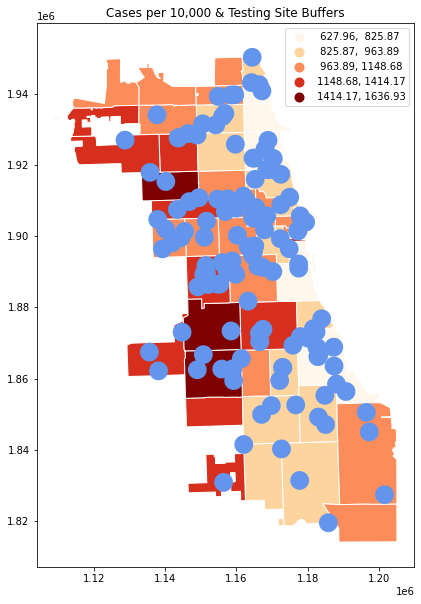

In [42]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_aspect('equal')
ax.set_title('Cases per 10,000 & Testing Site Buffers')

cumulativecasesgdf.plot(ax=ax, column="CasesPer10000", legend=True, cmap="OrRd", scheme="NaturalBreaks", edgecolor='white')

#testingsitesgdf.plot(ax=ax, color='crimson', zorder=10, markersize=20)
buffered_sites.plot(ax=ax, color='cornflowerblue', zorder=10, markersize=20)

plt.show();

I then created 'near' and 'not near' layers based on the buffers and merged them together. That way, I have one layer with polygons that are near and not near testing sites. This layer will be used for ANOVA analysis.

In [43]:
near_sites = gpd.overlay(censustractsgdf, buffered_sites, how='intersection')
not_near_sites = gpd.overlay(censustractsgdf, near_sites, how='difference')

In [44]:
near_sites["near_site"] = "Yes"
not_near_sites["near_site"] = "No"

In [45]:
merged = near_sites.append(not_near_sites)

<AxesSubplot:>

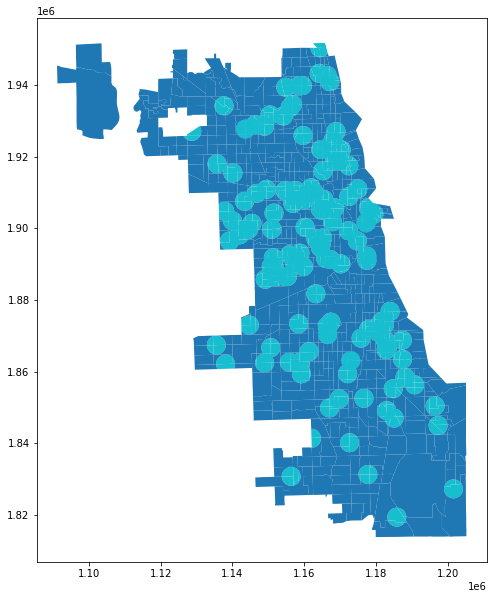

In [46]:
merged.plot(column="near_site", figsize=(15,10))

In [47]:
near_site_pctpoc = near_sites["PctPOC"]
not_near_site_pctpoc = not_near_sites["PctPOC"]
frame3 = {"near": near_site_pctpoc, "not_near": not_near_site_pctpoc}
analysisdf = pd.DataFrame(frame3)

df_melt = pd.melt(analysisdf.reset_index(), id_vars=['index'], value_vars=['near', 'not_near'])
df_melt = df_melt.drop("index", axis=1)

In [48]:
df_melt.columns

Index(['variable', 'value'], dtype='object')

In [49]:
averages = df_melt.groupby('variable').mean()
averages

,value
variable,
near,0.556351
not_near,0.590946


In [50]:
model = ols('value ~ variable', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
variable,1.0,0.513134,0.513134,5.094665,0.024119
Residual,1803.0,181.598055,0.100720,NaN,NaN


In [51]:
near_sites_cases = gpd.overlay(cumulativecasesgdf, buffered_sites, how='intersection')
not_near_sites_cases = gpd.overlay(cumulativecasesgdf, near_sites, how='difference')

In [52]:
near_sites_cases["near_site"] = "Yes"
not_near_sites_cases["near_site"] = "No"

In [53]:
merged_cases = near_sites_cases.append(not_near_sites_cases)

<AxesSubplot:>

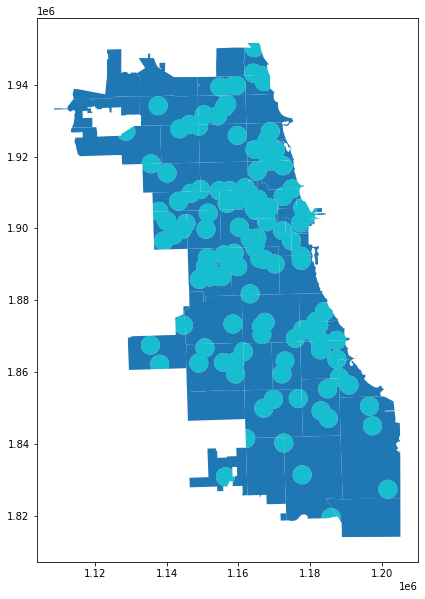

In [54]:
merged_cases.plot(column="near_site", figsize=(15,10))

In [55]:
near_site_cases_pctpoc = near_sites_cases["CasesPer10000"]
not_near_site_pctpoc_cases = not_near_sites_cases["CasesPer10000"]
frame4 = {"near": near_site_cases_pctpoc, "not_near": not_near_site_pctpoc_cases}
analysisdf_cases = pd.DataFrame(frame4)

df_melt_cases = pd.melt(analysisdf_cases.reset_index(), id_vars=['index'], value_vars=['near', 'not_near'])
df_melt_cases = df_melt_cases.drop("index", axis=1)
df_melt_cases

,variable,value
0,near,1054.063011
1,near,1030.060804
2,near,1054.063011
3,near,1030.060804
4,near,870.309082
...,...,...
645,not_near,1318.577792
646,not_near,1587.572642
647,not_near,871.123120
648,not_near,818.266110


In [56]:
averages_cases = df_melt_cases.groupby('variable').mean()
averages_cases

,value
variable,
near,1026.245390
not_near,1029.456764


In [57]:
model_cases = ols('value ~ variable', data=df_melt_cases).fit()
anova_table_cases = sm.stats.anova_lm(model_cases)
anova_table_cases

,df,sum_sq,mean_sq,F,PR(>F)
variable,1.0,4.859926e+02,485.992648,0.00959,0.922049
Residual,327.0,1.657140e+07,50677.058446,NaN,NaN


# Visualization

<AxesSubplot:>

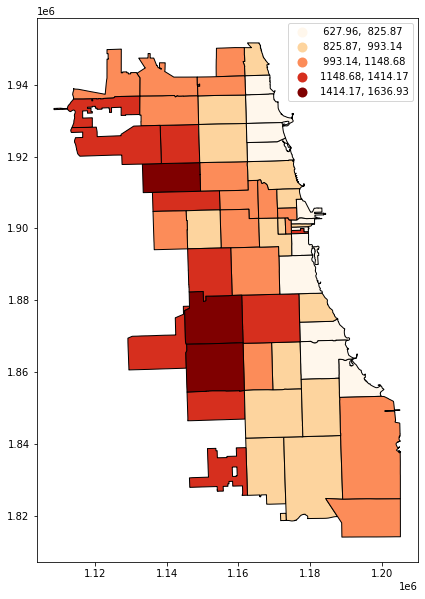

In [76]:
cumulativecasesgdf.plot(column="CasesPer10000", figsize=(15,10), legend=True, edgecolor="black", cmap="OrRd", scheme="NaturalBreaks")

<AxesSubplot:>

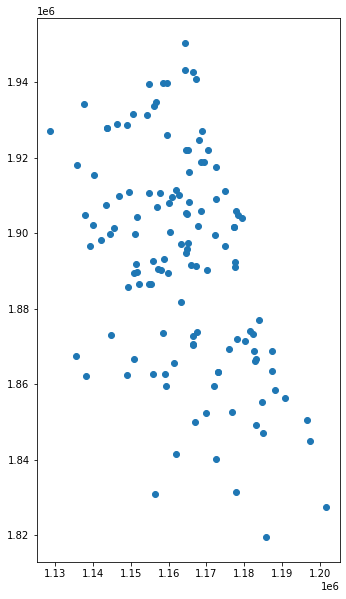

In [60]:
testingsitesgdf.plot(figsize=(15,10), legend=True)

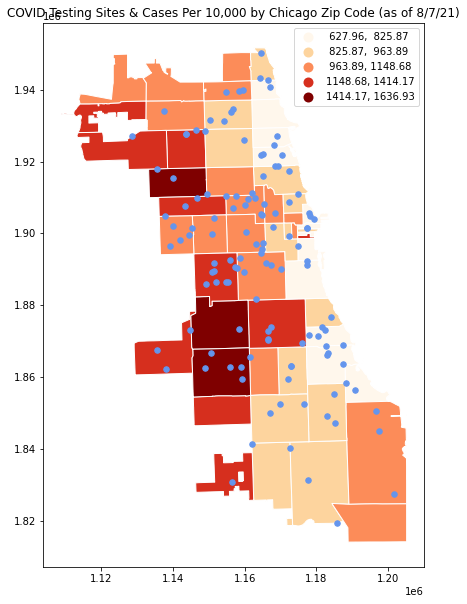

In [77]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')
ax.set_title('COVID Testing Sites & Cases Per 10,000 by Chicago Zip Code (as of 8/7/21)')

cumulativecasesgdf.plot(ax=ax, column="CasesPer10000", legend=True, cmap="OrRd", scheme="NaturalBreaks", edgecolor='white')

testingsitesgdf.plot(ax=ax, marker='o', color='cornflowerblue', markersize=30)

plt.show();

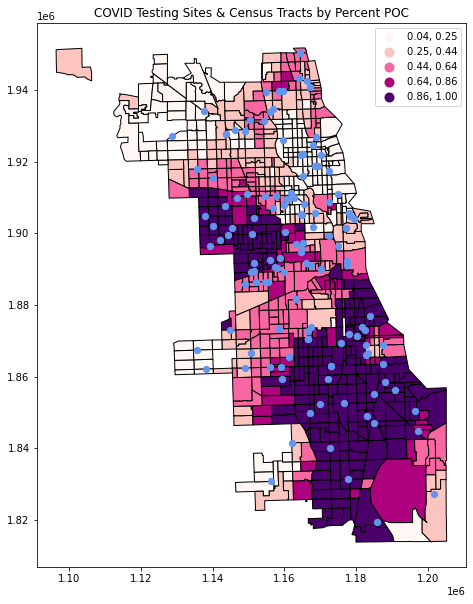

In [62]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')
ax.set_title('COVID Testing Sites & Census Tracts by Percent POC')

censustractsgdf.plot(ax=ax, column="PctPOC", figsize=(20,15), legend=True, edgecolor="black", 
                     cmap="RdPu", scheme="NaturalBreaks")

testingsitesgdf.plot(ax=ax, marker='o', color='cornflowerblue', markersize=40)

plt.show();

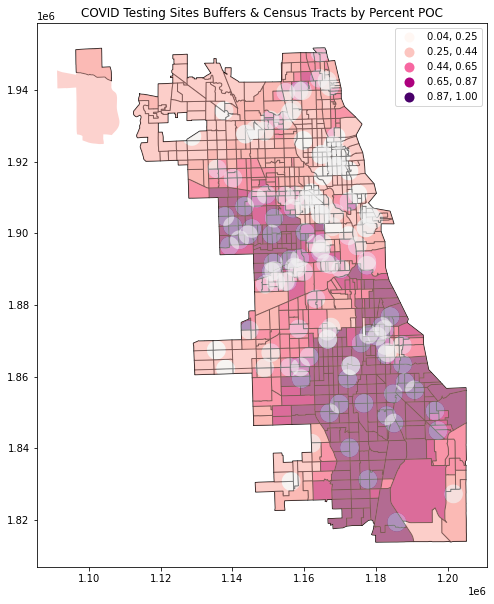

In [63]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')
ax.set_title('COVID Testing Sites Buffers & Census Tracts by Percent POC')

censustractsgdf.plot(ax=ax, column="PctPOC", legend=True, edgecolor="black", cmap="RdPu", scheme="NaturalBreaks")

merged.plot(ax=ax, column="near_site", alpha=0.6, cmap="Pastel1")

plt.show();

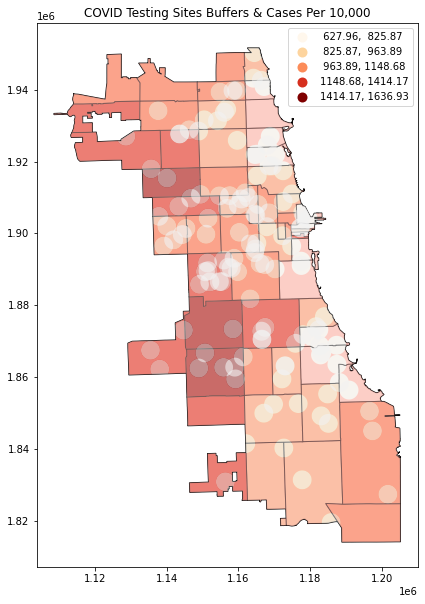

In [64]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_aspect('equal')
ax.set_title('COVID Testing Sites Buffers & Cases Per 10,000')

cumulativecasesgdf.plot(ax=ax, column="CasesPer10000", legend=True, edgecolor="black", cmap="OrRd", scheme="NaturalBreaks")

merged_cases.plot(ax=ax, column="near_site", alpha=0.6, cmap="Pastel1")

plt.show();

# Analysis and Results

In [65]:
averages

,value
variable,
near,0.556351
not_near,0.590946


In [66]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
variable,1.0,0.513134,0.513134,5.094665,0.024119
Residual,1803.0,181.598055,0.100720,NaN,NaN


My results indicate that the areas near Chicago's COVID-19 testing sites (within a half mile) are on average about 4% whiter than areas not near testing sites. This difference is small but statistically significant, with a p-value of 0.024.

In [67]:
averages_cases

,value
variable,
near,1026.245390
not_near,1029.456764


In [68]:
anova_table_cases

,df,sum_sq,mean_sq,F,PR(>F)
variable,1.0,4.859926e+02,485.992648,0.00959,0.922049
Residual,327.0,1.657140e+07,50677.058446,NaN,NaN


I did not find any statistically significant difference between the COVID case rate near testing sites and not near testing sites. There was an average of just 3 more cases per 10,000 people in the "not near" group, and the p-value of 0.922 clearly indicates no relationship.

# Conclusions

A large benefit of this project was the discovery of a statistically significant difference between racial breakdowns near and not near COVID testing sites. I found that areas with accessible testing sites are 4% whiter than areas without accessible testing. This finding is an example of the allocation of health resources being disparate along racial lines, which has of course contributed to disparate impacts of the pandemic.

Though I did not find a statistically significant difference between COVID case rates near and not near testing sites, this finding is not too surprising. It illustrates that, perhaps, Chicago did not purposely add testing sites to areas that had more COVID cases. That may be an area for future work for health officials in cities.

One large limitation of this project was the method of calculating what is "near" a testing site. I wanted to create service areas using network analysis, but the timescale of the project and available open source packages did not allow for this method. Instead, I used half-mile buffers. These buffers can still give us a sense of what is within walking distance, especially since Chicago's sidewalks are close to a uniform grid, but they do not fully encompass what it means for a location to be accessible. People may access COVID-19 testing  by driving, biking, using public transportation, getting a ride from a friend, or (now that over the counter rapid tests are available) by ordering pharmacy delivery. I acknowledge this limitation of my analysis but still find it useful to investigate the physical locations of testing sites and the demographics of people who live near them.

Another limitation is the way that I measured COVID distribution across Chicago. The most granular data available was at the zip code level, and it would have been helpful to have data at the Census tract level, especially to stay consistent with my demographic data. Additionally, I chose to use the measure of cumulative cases for each zip code and create a measure of cases-to-date per 10,000. This measure does not reflect fluctuations throughout the pandemic or movements of testing sites throughout the city. It is, however, a snapshot of the cumulative impact of COVID throughout the city.

# References
Benitez, J., Courtemanche, C. & Yelowitz, A. (2020). Racial and Ethnic Disparities in COVID-19: Evidence from Six Large Cities. J Econ Race Policy 3, 243–261. https://doi.org/10.1007/s41996-020-00068-9.

Nelson, R., Madron, J., Ayers, N., Winling, L., Marciano, R., Jansen, G., Lee, M., Shah, S., Kending, M. & Connolly, N. D. B. Mapping Inequality: Redlining in New Deal America. University of Richmond’s Digital Scholarship Lab. https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58.

Onésimo Sandoval, J. S. (2011). Neighborhood Diversity and Segregation in the Chicago Metropolitan Region, 1980-2000. Urban Geography, 32(5), 609-640. https://doi.org/10.2747/0272-3638.32.5.609.